# Reinforcement Learning with Q-Learning
G. Ayorkor Korsah

Demonstration code for DSA Africa 2018 (Abuja) - November 2018

Note: The second part of this example code requires the installation of OpenAI Gym: https://gym.openai.com/


## Implementation of Basic Q-Learning

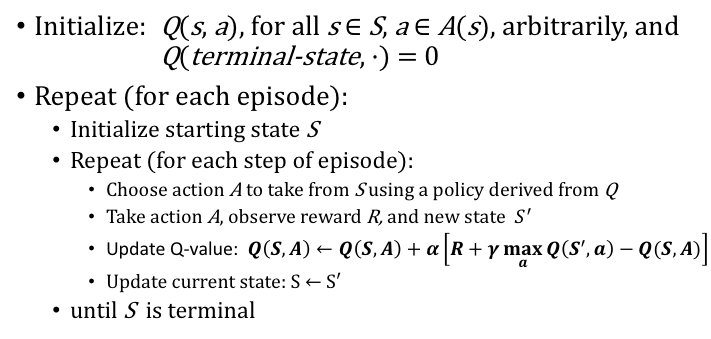

In [ ]:
import numpy as np
import random
from IPython.display import clear_output

def q_learn(n_states, n_actions, state_transition_fxn, params, n_epochs):
    alpha = params["alpha"]
    gamma = params["gamma"]
    epsilon = params["epsilon"]
    q_table = np.zeros([n_states, n_actions])

    # For plotting metrics
    avg_state_values = []
    steps_per_epoch = []
    total_rewards = []

    for i in range(1, n_epochs+1):
        state = random.randrange(n_states) # start training epoch in a random state

        steps, rewards = 0, 0
        done = False

        while not done:
        
            # Choose action to take
            # Explore with probability of epsilon and exploit with probability (1-epsilon)
            if random.uniform(0, 1) < epsilon:
                action = random.randrange(n_actions) # explore by picking a random action
            else:
                action = np.argmax(q_table[state]) # exploit by picking the best action at this state

            # execute the given action
            next_state, reward, done = state_transition_fxn(state, action) 

            # Compute updated Q-value
            old_Qvalue = q_table[state, action]
            next_max = np.max(q_table[next_state])
            new_Qvalue = (1 - alpha) * old_Qvalue + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_Qvalue
            state = next_state

            rewards += reward
            steps += 1

        avg_state_values.append(np.mean(np.max(q_table,axis=1)))
        steps_per_epoch.append(steps)
        total_rewards.append(rewards)
        
        if i % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {i}")

    print("Training finished.\n")
    return q_table, avg_state_values, steps_per_epoch, total_rewards

## Toy Example
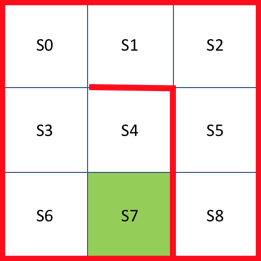
Actions: A0 - up, A1 - right, A2 - down, A3 - left, A4 - stay

Goal state in green.

Penalties: -1 for each step into a free non-goal cell (including staying in the current cell), -5 for each attempt to step into a wall (whether external or internal), +50 for reaching the goal

In [ ]:
# Reward/penalty values
step = -1
wall = -5
goal = 50

actions = {0:"up",1:"right",2:"down",3:"left",4:"stay"}

state_trans_table = [[0,1,3,0,0],#Transitions from S0 - next state for each of the 5 actions
                     [1,2,1,0,1],#S1
                     [2,2,5,1,2],#S2
                     [0,4,6,3,3],#S3
                     [4,4,7,3,4],#S4
                     [2,5,8,5,5],#S5
                     [3,7,6,6,6],#S6
                     [4,7,7,6,7],#S7
                     [5,8,8,8,8]#S8
                    ]

reward_table = [[wall,step,step,wall,step],#Rewards for each action taken from S0
                [wall,step,wall,step,step],#S1
                [wall,wall,step,step,step],#S2
                [step,step,step,wall,step],#S3
                [wall,wall,goal,step,step],#S4
                [step,wall,step,wall,step],#S5
                [step,goal,wall,wall,step],#S6
                [step,wall,wall,step,0],#S7 -- see note below
                [step,wall,wall,wall,step] #S8
               ]
# Note that if we start in S7 and stay, we incur no reward or penalty


In [ ]:
def toy_state_trans_fxn(state, action):
    next_state = state_trans_table[state][action]
    reward = reward_table[state][action]
    done = (next_state == 7)
    return (next_state, reward, done)

In [ ]:
print("Testing state transition")
s = int(input("Enter state: "))
a = int(input("Enter action: "))
next_state, reward, done = toy_state_trans_fxn(s, a)
print(f"Next state=S{next_state}, reward={reward}, done={done}")

In [ ]:
%%time
# TRAIN THE AGENT
# First, specify the hyperparameters
params = {"alpha":0.5,    # learning rate - how much we update Q value on each iteration 0 < alpha <= 1
          "gamma":0.6,    # discount factor - how important are future rewards? 0 <= gamma <= 1
          "epsilon":0.1  # exporation - exploitation tradeoff
         }
# Then run q-learning
q_table, avg_state_values, steps_per_epoch, total_rewards = \
        q_learn(len(state_trans_table),len(state_trans_table[0]), 
                    toy_state_trans_fxn, params, 3000)

# Plot the average value function as learning progressed
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(avg_state_values)
print(f"Max average state value across all epochs {max(avg_state_values)}")


In [ ]:
print("Q-table")
print(q_table,"\n")

for s in range(len(state_trans_table)):
    best_action = np.argmax(q_table[s])
    print(f"Best action from S{s} is A{best_action}:{actions[best_action]} resulting in S{state_trans_table[s][best_action]}")

## OpenAI Gym Taxi-V2 Example
"Gym is a toolkit for developing and comparing reinforcement learning algorithms"

See https://gym.openai.com/docs/ for installation instructions

In [ ]:
import gym
taxi_env = gym.make("Taxi-v2").env
action_meanings = {0:"down", 1:"up", 2:"right", 3:"left", 4:"pick-up", 5:"drop-off"}
print("State Space {}".format(taxi_env.observation_space))
print("Action Space {}".format(taxi_env.action_space))
print("Action meanings", action_meanings)
print("Legend: Blue - pickup loc, Purple - dropoff loc, yellow taxi - empty, green taxi - full")
print("Sample state:")
taxi_env.render()

In [ ]:
def taxi_state_trans_fxn(state, action):
    taxi_env.s = state
    next_state, reward, done, info = taxi_env.step(action)
    return (next_state, reward, done)

In [ ]:
%%time
"""Training the agent"""
params = {"alpha":0.1,    # learning rate - how much we update Q value on each iteration 0 < alpha <= 1
          "gamma":0.6,    # discount factor - how important are future rewards? 0 <= gamma <= 1
          "epsilon":0.1  # exporation - exploitation tradeoff
         }
q_table, avg_state_values, steps_per_epoch, total_rewards = \
        q_learn(taxi_env.observation_space.n, taxi_env.action_space.n, 
                taxi_state_trans_fxn, params, 20000)
plt.plot(avg_state_values)
print(f"Max average state value across all epochs {max(avg_state_values)}")

In [ ]:
s = int(input("Input a state to examine: "))
print("Visualizing state {}.".format(s))
print("Legend: Blue - pickup loc, Purple - dropoff loc, yellow taxi - empty, green taxi - full")
taxi_env.reset()
taxi_env.s = s
taxi_env.render()
print("Q-values for state {}:".format(s))
print(q_table[s])
print("Action meanings", action_meanings)
best_action = np.argmax(q_table[s])
print(f"Policy advocates action {best_action}: {action_meanings[best_action]}")